In [1]:
# https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py
import os
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb

from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from src.models.train_model import fit_model, get_metrics, get_preds

In [3]:
DATA_DIR ='../data'
RAW_DIR =  os.path.join(DATA_DIR, 'raw/')
EXTERNAL_DIR = os.path.join(DATA_DIR, 'external/')
TRAIN_DATA = os.path.join(RAW_DIR, 'train.csv')
STOPWORDS_DIR = os.path.join(EXTERNAL_DIR, 'stopwords.txt')

In [4]:
from src.features.build_features import get_stopwords

In [5]:
df = pd.read_csv(TRAIN_DATA, delimiter='|')
df

,Pregunta,Intencion
0,como puedo trabajar en santander rio,Cat_102
1,pagar tarjeta visa querer reintegro,Cat_350
2,pagar tarjeta naranja sistema,Cat_132
3,no se debitó la primera cuota del plan de bien...,Cat_129
4,abonar tarjeta credito,Cat_342
...,...,...
20099,el monto del prestamo depende de los ingresos???,Cat_251
20100,quiero cancelar una compra puntual el cuotas,Cat_339
20101,necesito pagar deuda,Cat_192
20102,teniendo otro hipotecario es posible aplicar p...,Cat_218


In [6]:
STOPWORDS = get_stopwords(STOPWORDS_DIR)

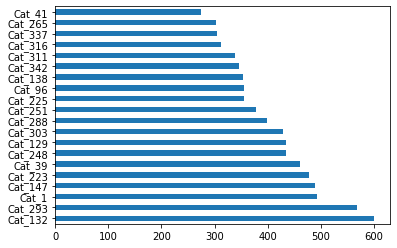

In [7]:
df.Intencion.value_counts().nlargest(20).plot.barh()

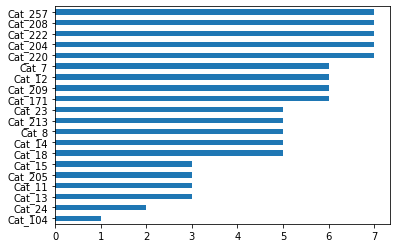

In [8]:
df.Intencion.value_counts().nsmallest(20).plot.barh()

In [9]:
# eliminamos la que tiene solo 1,2 etiqueta para poder entrenar en 2 splits
categories = df.Intencion.value_counts()[df.Intencion.value_counts()>2].index

In [10]:
df = df[df.Intencion.isin(categories)]
X = df.Pregunta
y = df.Intencion

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify=y)

In [12]:
preprocess =  Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words=STOPWORDS,
        ngram_range=(1,2),
        # max_features=10000, 
#         min_df=0.005,
        sublinear_tf=True
    )),
])

In [13]:
preprocess.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['0', '1', '2', '3', '4', '5', '6',
                                             '7', '8', '9', 'a', 'actualmente',
                                             'acuerdo', 'adelante', 'ademas',
                                             'adrede', 'afirmo', 'agrego',
                                             'ahi', 'ahora', 'al', 'algo',
                                             'algun', 'alguna', 'algunas',
                                             'alguno', 'algunos', 'alli',
                                             'alrededor', 'ambos', ...],
                                 sublinear_tf=True))])

In [14]:
preprocess.transform(X_train).shape,
# preprocess.steps[0][1].get_feature_names()

((14070, 26336),)

In [ ]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

logistic = LogisticRegression(C=3.73, n_jobs=4, class_weight='balanced')

clf = RandomizedSearchCV(logistic, hyperparameters, random_state=42, n_iter=10, cv=3, verbose=0, n_jobs=3, scoring='balanced_accuracy')

fit_model(clf, preprocess, X_train, y_train)

print('Best Penalty:', clf.best_estimator_.get_params()['penalty'])
print('Best C:', clf.best_estimator_.get_params()['C'])

/home/jloscalzo/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
get_metrics(clf.best_estimator_, preprocess, X_train, y_train, X_test, y_test)

In [ ]:
model = Pipeline([
  ("preprocess", preprocess),
  ("model", logistic)
])

X = df.Pregunta
y = df.Intencion

model.fit(X,y)

In [ ]:
test = pd.read_csv(TEST_DATA, delimiter=',')
test
preds = pd.DataFrame(zip(test["id"], model.predict(test.Pregunta)))
preds.iloc[:,1] = preds.iloc[:,1].str.replace('Cat_', '')

In [69]:
from datetime import datetime
now = datetime.now().strftime("%Y%m%d_%H%M")
preds.to_csv(f'../data/results/answers_{now}.csv', header=False, index=False)

'20200629_1345'